# Features Preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import os
from tqdm import tqdm
from typing import List, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import rankdata, skew, kurtosis
from scipy.stats.mstats import winsorize

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score 

In [2]:
data=pd.read_csv('train_titanic.csv')
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


<AxesSubplot:xlabel='Age'>

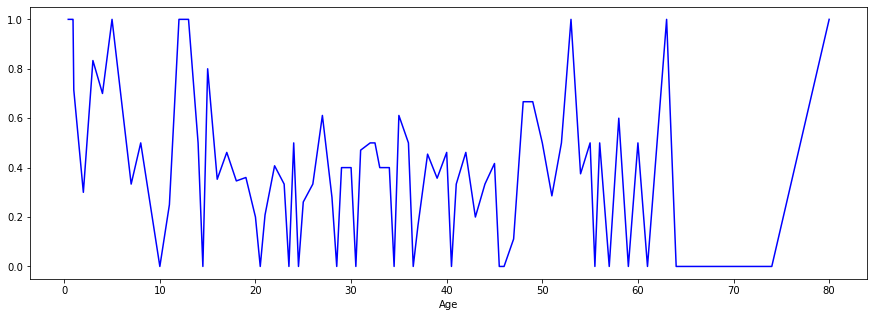

In [3]:
fig=plt.figure(figsize=(15,5))
data.groupby(['Age'])['Survived'].mean().plot(color='blue')

Text(0, 0.5, 'target')

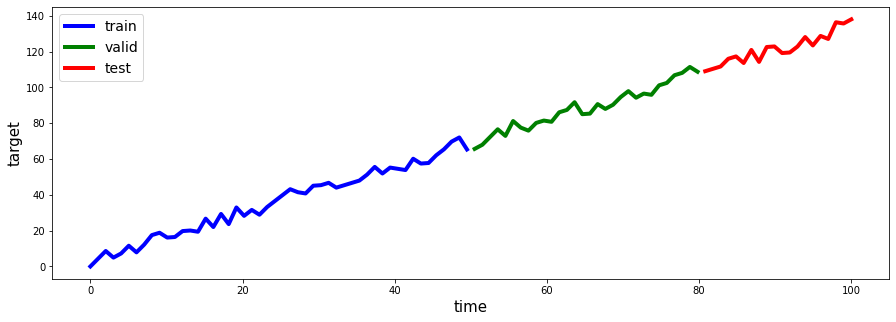

In [4]:
x=np.linspace(0, 100, 100)
y=1.3*x + np.random.randint(0, 10, size=x.shape[0])

plt.figure(figsize=(15, 5))
plt.plot(x[:50], y[:50], linewidth=4, color='blue',label='train')
plt.plot(x[50:80], y[50:80], linewidth=4, color='green',label='valid')
plt.plot(x[80:], y[80:], linewidth=4, color='red',label='test')
plt.legend(loc='best', fontsize=14)
plt.xlabel('time', size=15)
plt.ylabel('target', size=15)

## Numeric features

In [5]:
features=['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
target= 'Survived'
estimator=RandomForestClassifier(random_state=27, n_jobs=4)

In [6]:
%%time
cv=cross_val_score(
    estimator=estimator,
    X=data[features].fillna(-9999),
    y=data[target],
    scoring='roc_auc',
    cv=3
)

print(f'CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv),3)}')

CV-result: 0.7225 +/- 0.02
Wall time: 1.51 s


In [7]:
data_trans=data[features].copy()
data_trans['Age']=100*data_trans['Age']

cv=cross_val_score(
    estimator=estimator,
    X=data_trans[features].fillna(-9999),
    y=data[target],
    scoring='roc_auc',
    cv=3
)

print(f'CV-result: {round(np.mean(cv), 4)} +/- {round(np.std(cv),3)}')

CV-result: 0.7225 +/- 0.02


In [8]:
estimator = LogisticRegression(random_state=27)

pipeline_std = Pipeline(steps=[('scaling', StandardScaler()), ('estimator', estimator)])

pipeline_mm = Pipeline(steps=[('scaling', MinMaxScaler()), ('estimator', estimator)])

In [9]:
%%time
cv_std=cross_val_score(
    estimator=pipeline_std,
    X=data[features].fillna(0),
    y=data[target],
    scoring='roc_auc',
    cv=3
)

print(f'CV-result: {round(np.mean(cv_std), 4)} +/- {round(np.std(cv_std),3)}')

cv_mm=cross_val_score(
    estimator=pipeline_mm,
    X=data[features].fillna(0),
    y=data[target],
    scoring='roc_auc',
    cv=3
)

print(f'CV-result: {round(np.mean(cv_mm), 4)} +/- {round(np.std(cv_mm),3)}')

CV-result: 0.7152 +/- 0.056
CV-result: 0.7145 +/- 0.059
Wall time: 71.4 ms


In [10]:
def linear_model_fit_transform(X: np.array, y: np.array) -> np.array:
    
    model = LinearRegression()
    model.fit(X.reshape(X.shape[0], -1), y)
    y_pred=model.coef_*X+model.intercept_
    
    return y_pred

In [11]:
x = np.arange(0, 1000, 2)
x = x + np.random.randint(0, 100, x.shape[0])
y = 3*x + 200*np.random.randn(x.shape[0])

y_pred = linear_model_fit_transform(x, y)

Text(0, 0.5, 'target')

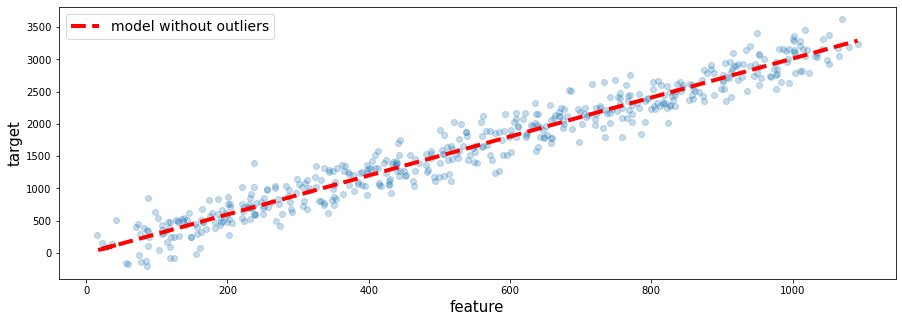

In [12]:
plt.figure(figsize=(15, 5))
plt.scatter(x, y, alpha=0.25)
plt.plot(x, y_pred, linewidth=4, color='red', linestyle='--', label='model without outliers')
plt.legend(loc='best', fontsize=14)
plt.xlabel('feature', size=15)
plt.ylabel('target', size=15)

In [13]:
x_outliers = x.copy()
x_outliers[0] = 10000

y_outliers_pred = linear_model_fit_transform(x_outliers, y)

Text(0, 0.5, 'target')

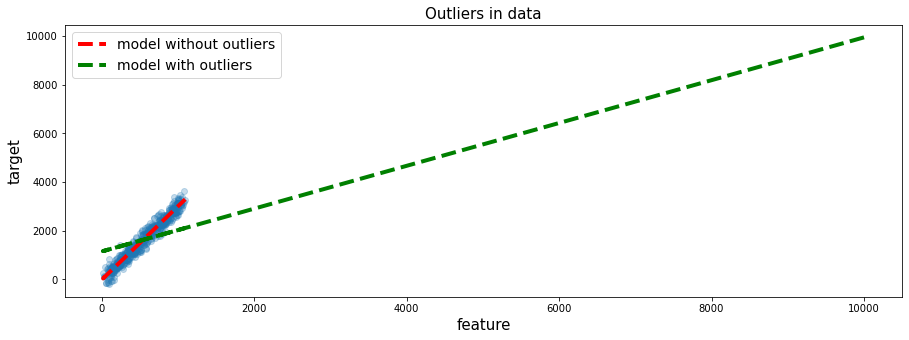

In [14]:
plt.figure(figsize=(15, 5))
plt.scatter(x, y, alpha=0.25)
plt.title('Outliers in data', size=15)
plt.plot(x, y_pred, linewidth=4, color='red', linestyle='--', label='model without outliers')
plt.plot(x_outliers, y_outliers_pred, linewidth=4, color='green', linestyle='--', label='model with outliers')
plt.legend(loc='best', fontsize=14)
plt.xlabel('feature', size=15)
plt.ylabel('target', size=15)

In [15]:
LEFT_BOUND, RIGHT_BOUND = np.percentile(x_outliers, q=1), np.percentile(x_outliers, q=99)
x_winsorized = np.clip(x_outliers, LEFT_BOUND, RIGHT_BOUND)
assert x_winsorized.shape[0] == x_outliers.shape[0]

Text(0, 0.5, 'target')

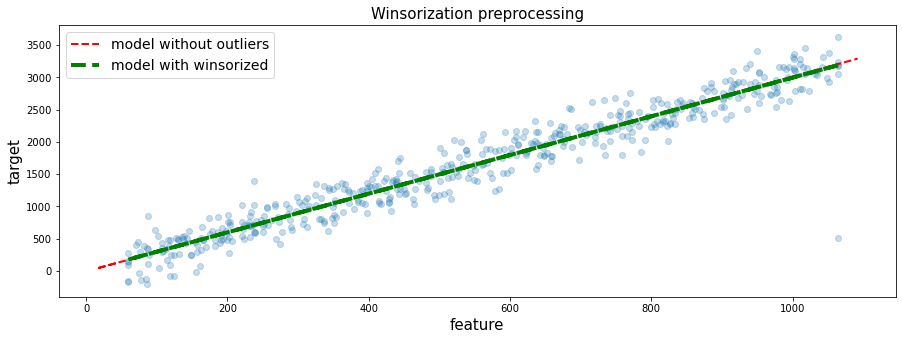

In [16]:
y_winsorized_pred = linear_model_fit_transform(x_winsorized, y)

plt.figure(figsize=(15, 5))
plt.scatter(x_winsorized, y, alpha=0.25)
plt.title('Winsorization preprocessing', size=15)
plt.plot(x, y_pred, linewidth=2, color='red', linestyle='--', label='model without outliers')
plt.plot(x_winsorized, y_winsorized_pred, linewidth=4, color='green', linestyle='--', label='model with winsorized')
plt.legend(loc='best', fontsize=14)
plt.xlabel('feature', size=15)
plt.ylabel('target', size=15)

In [17]:
x_rank = rankdata(x)
x_outliers_rank = rankdata(x_outliers)

y_pred_rank = linear_model_fit_transform(x_rank, y)
y_outliers_pred_rank = linear_model_fit_transform(x_outliers_rank, y)

Text(0, 0.5, 'target')

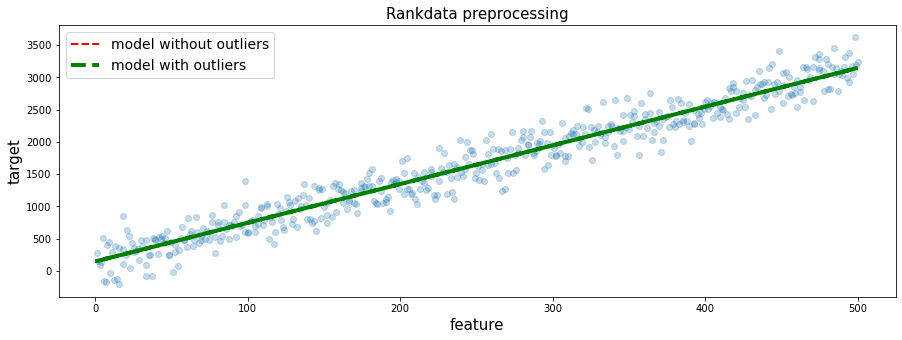

In [18]:
plt.figure(figsize=(15, 5))
plt.scatter(x_rank, y, alpha=0.25)
plt.title('Rankdata preprocessing', size=15)
plt.plot(x_rank, y_pred_rank, linewidth=2, color='red', linestyle='--', label='model without outliers')
plt.plot(x_outliers_rank, y_outliers_pred_rank, linewidth=4, color='green', linestyle='--', label='model with outliers')
plt.legend(loc='best', fontsize=14)
plt.xlabel('feature', size=15)
plt.ylabel('target', size=15)

## Categorical features

In [19]:
freq_encoder = data['Embarked'].value_counts()
data['Embarked_freq_enc'] = data['Embarked'].map(freq_encoder)
data[['Embarked', 'Embarked_freq_enc']].head(4)

,Embarked,Embarked_freq_enc
0,S,644.0
1,C,168.0
2,S,644.0
3,S,644.0


In [20]:
pd.get_dummies(data['Embarked']).head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


## Datetime features

In [21]:
data = pd.read_csv('train_sber_hous_market.csv', parse_dates=['timestamp'])
data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [28]:
start_date = data['timestamp'].min()

data['yearmonth'] = data['timestamp'].dt.year*100 + data['timestamp'].dt.month
data['yearweek'] = data['timestamp'].dt.year*100 + data['timestamp'].dt.weekofyear
data['year'] = data['timestamp'].dt.year

data['month_of_year'] = data['timestamp'].dt.month
data['week_of_year'] = data['timestamp'].dt.weekofyear
data['day_of_week'] = data['timestamp'].dt.weekday
data['diff_date'] = data['timestamp'].apply(lambda x: (x-start_date).days)

data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,sport_count_5000,market_count_5000,price_doc,yearmonth,yearweek,year,month_of_year,week_of_year,day_of_week,diff_date
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,52,4,5850000,201108,201133,2011,8,33,5,0
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,66,14,6000000,201108,201134,2011,8,34,1,3
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,67,10,5700000,201108,201134,2011,8,34,5,7
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,26,3,13100000,201109,201135,2011,9,35,3,12
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,195,14,16331452,201109,201136,2011,9,36,0,16


# Home Worky

In [27]:
df=pd.read_csv('application_train.csv')
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
search = 427000
l = df.loc[df.isin([search]).any(axis=1)].index.tolist()
l

[282352]

In [25]:
df.iloc[[282352]]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
282352,427000,0,Cash loans,F,N,Y,2,247500.0,607500.0,29353.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [26]:
df[df['SK_ID_CURR']==456254] # = 

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# End Home Work. Continuaton workshop

# Group

In [40]:
df.groupby(['NAME_CONTRACT_TYPE']).count()


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
NAME_CONTRACT_TYPE,,,,,,,,,,,,,,,,,,,,,
Cash loans,278232,278232,278232,278232,278232,278232,278232,278232,278220,278232,...,278232,278232,278232,278232,240993,240993,240993,240993,240993,240993
Revolving loans,29279,29279,29279,29279,29279,29279,29279,29279,29279,29001,...,29279,29279,29279,29279,24999,24999,24999,24999,24999,24999


In [44]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df.loc[df.groupby(['NAME_CONTRACT_TYPE'])['SK_ID_CURR'].count()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
278232,422364,0,Cash loans,M,N,Y,0,157500.0,614223.0,31491.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
29279,134005,0,Cash loans,F,N,Y,1,180000.0,473760.0,53581.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
df.loc[df.groupby(['NAME_CONTRACT_TYPE']).count()['SK_ID_CURR']]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
278232,422364,0,Cash loans,M,N,Y,0,157500.0,614223.0,31491.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
29279,134005,0,Cash loans,F,N,Y,1,180000.0,473760.0,53581.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df.groupby(['NAME_CONTRACT_TYPE'])['SK_ID_CURR'].count()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: SK_ID_CURR, dtype: int64

In [92]:
df.groupby('NAME_CONTRACT_TYPE').count()[['SK_ID_CURR']]
#df.groupby('user_id').sum()[['item_total','promo_total','total_weight','item_count']]

,SK_ID_CURR
NAME_CONTRACT_TYPE,
Cash loans,278232
Revolving loans,29279


In [85]:
df[['NAME_CONTRACT_TYPE', 'SK_ID_CURR']].groupby('NAME_CONTRACT_TYPE').count()

,SK_ID_CURR
NAME_CONTRACT_TYPE,
Cash loans,278232
Revolving loans,29279


In [64]:
df[['NAME_CONTRACT_TYPE', 'SK_ID_CURR', 'CODE_GENDER']].groupby('NAME_CONTRACT_TYPE').count()

,SK_ID_CURR,CODE_GENDER
NAME_CONTRACT_TYPE,,
Cash loans,278232,278232
Revolving loans,29279,29279


In [90]:
df[['NAME_CONTRACT_TYPE', 'SK_ID_CURR', 'CODE_GENDER']].groupby(['NAME_CONTRACT_TYPE', 'CODE_GENDER']).count()

SK_ID_CURR
NAME_CONTRACT_TYPE CODE_GENDER            
Cash loans         F                182800
                   M                 95432
Revolving loans    F                 19648
                   M                  9627
                   XNA                   4

In [106]:
#df[df['order_state'] == 'complete'].groupby('user_id').sum().sort_values(by='item_total', ascending=False)[['item_total','promo_total','total_weight','item_count']].head(10)

df[df['CODE_GENDER'] == 'M'].groupby('NAME_CONTRACT_TYPE').count()[['SK_ID_CURR']]

,SK_ID_CURR
NAME_CONTRACT_TYPE,
Cash loans,95432
Revolving loans,9627


In [111]:
df[df['CODE_GENDER'] == 'M'].groupby('NAME_CONTRACT_TYPE', as_index=False).count()[['SK_ID_CURR']]

,SK_ID_CURR
0,95432
1,9627


In [109]:
df[df['CODE_GENDER'] == 'M'].groupby('NAME_CONTRACT_TYPE', as_index=False).count()[['NAME_CONTRACT_TYPE', 'SK_ID_CURR']]

,NAME_CONTRACT_TYPE,SK_ID_CURR
0,Cash loans,95432
1,Revolving loans,9627


# End group